In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats

from NetFormer.data import data_simulator, generate_simulation_data
from NetFormer import tools, data, baselines

In [4]:
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
})

### Construct Data

In [6]:
neuron_num = 200
tau = 1

init_scale = 1
weight_scale = 1
error_scale = 3.5

total_time = 30000
data_random_seed = 42

simulator = data_simulator(
    neuron_num=neuron_num, 
    tau=tau, 
    weight_scale= weight_scale,
    init_scale=init_scale,
    error_scale=error_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
)

result = []

for t in range(total_time):
    x_t = simulator.forward(t)
    x_t = x_t.view(-1, 1)
    result.append(x_t)

result = np.concatenate(result, axis=1)
print(result.shape)

(200, 30000)


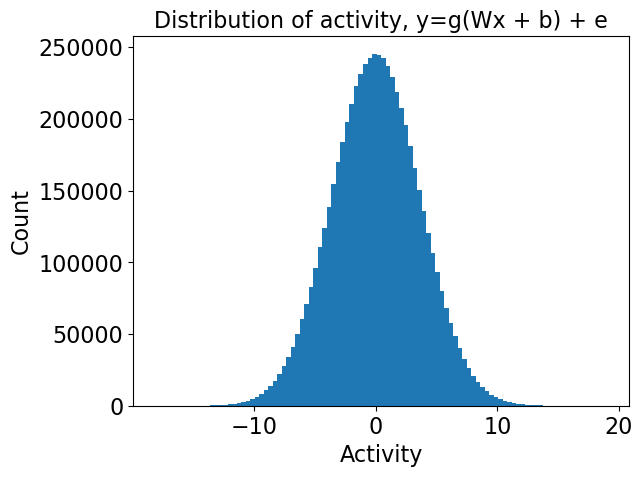

max activity:  18.987123
min activity:  -18.138117
medium activity:  0.009581253


In [7]:
plt.hist(result.flatten(), bins=100)
plt.title("Distribution of activity, y=g(Wx + b) + e")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.show()

max_activity = np.max(result)
print("max activity: ", max_activity)
min_activity = np.min(result)
print("min activity: ", min_activity)
medium_activity = np.median(result)
print("medium activity: ", medium_activity)

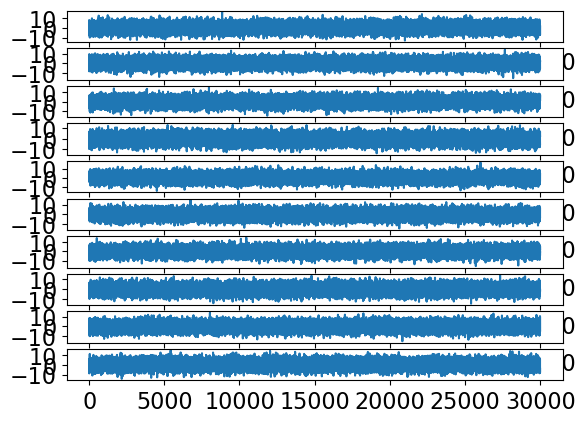

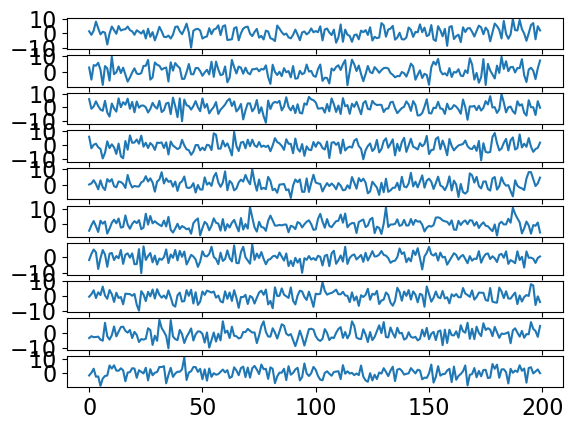

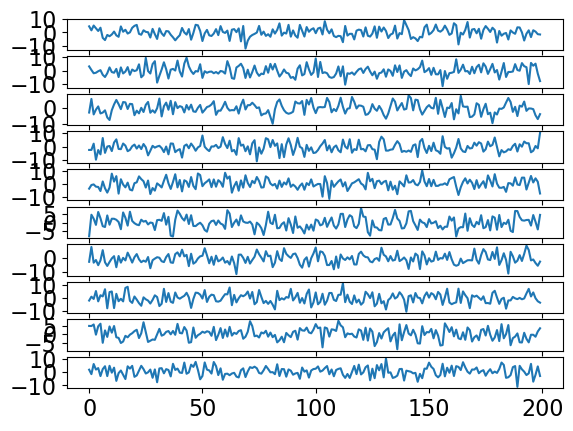

In [22]:
neuron_num = 10
for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][:200])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][5000:5200])
plt.show()

## Baselines

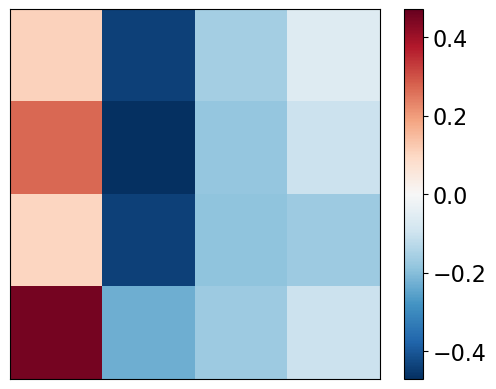

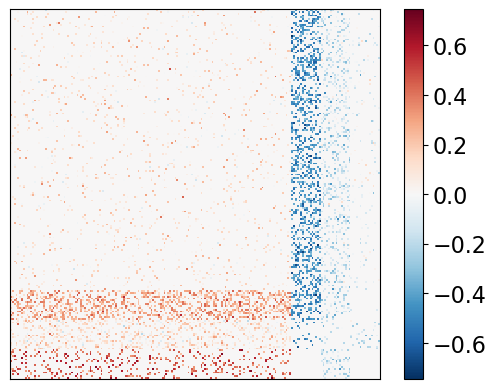

In [19]:
cell_type_id2cell_type = {0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}

window_size = 200
predict_window_size = 1

batch_size = 32
model_type = 'NetFormer'
spatial_partial_measurement = 200

data_result = data.generate_simulation_data(
    neuron_num=neuron_num,
    tau=tau,
    weight_scale=weight_scale,
    init_scale=init_scale,
    error_scale=error_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    window_size=window_size,
    predict_window_size=predict_window_size,
    batch_size=batch_size,
    model_type=model_type,
    spatial_partial_measurement=spatial_partial_measurement,
)

trainloader, validloader, weight_matrix, cell_type_ids, cell_type_order, cell_type_count = data_result

strength_matrix = np.load('../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')

max_abs = np.max(np.abs(strength_matrix))
vmin_KK = -max_abs
vmax_KK = max_abs
plt.imshow(strength_matrix, cmap='RdBu_r', interpolation='nearest', vmin=vmin_KK, vmax=vmax_KK)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()


weight_matrix = simulator.W_ij
weight_matrix = weight_matrix.detach().numpy()

max_abs = np.max(np.abs(weight_matrix))
vmin_NN = -max_abs
vmax_NN = max_abs
plt.imshow(weight_matrix, cmap='RdBu_r', interpolation='nearest', vmin=vmin_NN, vmax=vmax_NN)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

### Covariance Matrix

(200, 200)
pearson_corr_NN: -0.029189538496296012 spearman_corr_NN: -0.015033277442620443


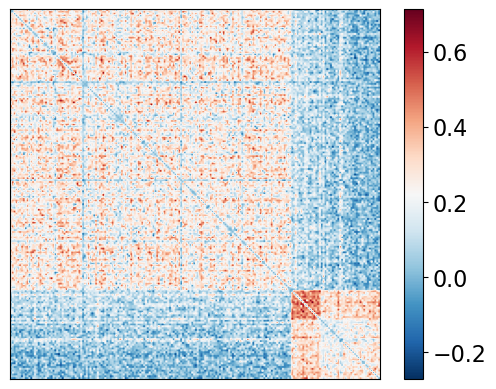

pearson_corr_KK: -0.43745204710343555 spearman_corr_KK: -0.3340711598308202


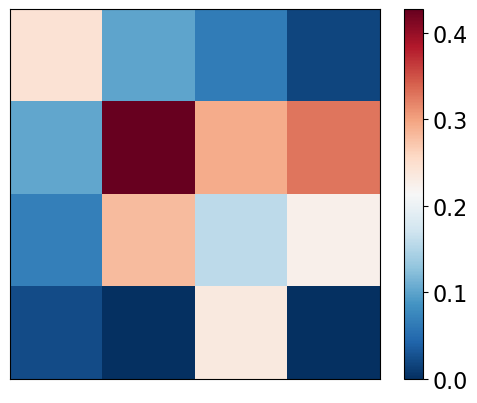

In [14]:
# calculate covariance matrix using activity

cov = np.cov(result)
cov = cov - np.diag(np.diag(cov)) 
print(cov.shape)
pearson_corr = np.corrcoef(cov.flatten(), weight_matrix.flatten())[0, 1]
spearman_corr = stats.spearmanr(cov.flatten(), weight_matrix.flatten())[0]
print('pearson_corr_NN:', pearson_corr, 'spearman_corr_NN:', spearman_corr)

# only red color
plt.imshow(cov, cmap='RdBu_r')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

KK_strength = tools.NN2KK_remove_no_connection_sim(
    connectivity_matrix_new=cov,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)
pearson_corr_KK = np.corrcoef(KK_strength.flatten(), strength_matrix.flatten())[0, 1]
spearman_corr_KK = stats.spearmanr(KK_strength.flatten(), strength_matrix.flatten())[0]
print('pearson_corr_KK:', pearson_corr_KK, 'spearman_corr_KK:', spearman_corr_KK)

plt.imshow(KK_strength, cmap='RdBu_r')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

### Cross Correlation

corr: 0.8225690171259289 spearman_corr: 0.5189344170704351


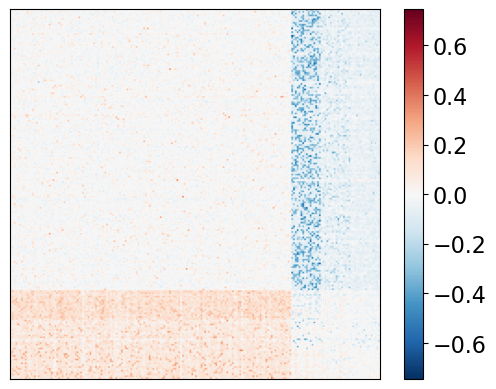

corr_strength_KK: 0.8889106640232607 spearman_corr_strength_KK: 0.7323016814834536


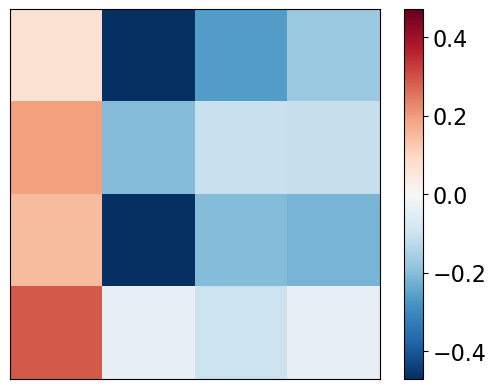

In [13]:
# get cross-correlation matrix
cross_corr = baselines.get_activity_cross_correlation(result, tau=1)

pearson_corr = np.corrcoef(cross_corr.flatten(), weight_matrix.flatten())[0, 1]
spearman_corr = stats.spearmanr(cross_corr.flatten(), weight_matrix.flatten())[0]
print('pearson_corr_NN:', pearson_corr, 'spearman_corr_NN:', spearman_corr)

transformed_cross_corr = tools.linear_transform(cross_corr, weight_matrix)
plt.imshow(transformed_cross_corr, cmap='RdBu_r', vmin=vmin_NN, vmax=vmax_NN)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

KK_strength = tools.NN2KK_remove_no_connection_sim(
    connectivity_matrix_new=cross_corr,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)
pearson_corr_KK = np.corrcoef(KK_strength.flatten(), strength_matrix.flatten())[0, 1]
spearman_corr_KK = stats.spearmanr(KK_strength.flatten(), strength_matrix.flatten())[0]
print('pearson_corr_KK:', pearson_corr_KK, 'spearman_corr_KK:', spearman_corr_KK)

transformed_KK_strength = tools.linear_transform(KK_strength, strength_matrix)
plt.imshow(transformed_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

### Transfer Entropy

pearson_corr_NN: 0.5998864069908082 spearman_corr_NN: 0.3389046379413004


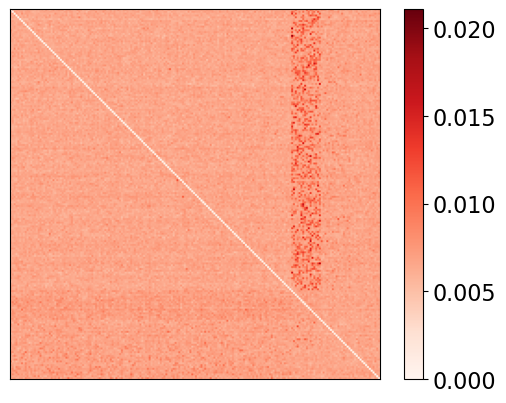

pearson_corr_KK: 0.41863036812497184 spearman_corr_KK: 0.3532913998333754


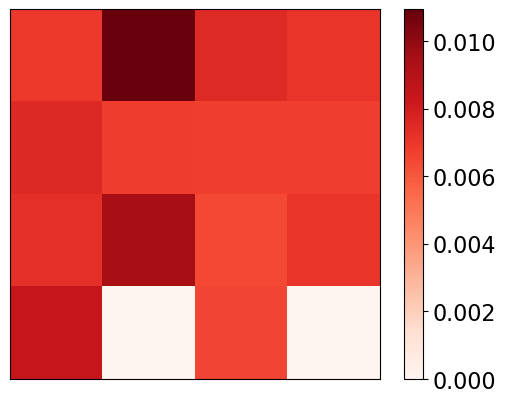

In [16]:
te = baselines.get_activity_transfer_entropy(result, history=1)

pearson_corr = np.corrcoef(te.flatten(), np.abs(weight_matrix).flatten())[0, 1]
spearman_corr = stats.spearmanr(te.flatten(), np.abs(weight_matrix).flatten())[0]
print('pearson_corr_NN:', pearson_corr, 'spearman_corr_NN:', spearman_corr)

plt.imshow(te, cmap='Reds')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

KK_strength = tools.NN2KK_remove_no_connection_sim(
    connectivity_matrix_new=te,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)
pearson_corr_KK = np.corrcoef(KK_strength.flatten(), np.abs(strength_matrix).flatten())[0, 1]
spearman_corr_KK = stats.spearmanr(KK_strength.flatten(), np.abs(strength_matrix).flatten())[0]
print('pearson_corr_KK:', pearson_corr_KK, 'spearman_corr_KK:', spearman_corr_KK)

plt.imshow(KK_strength, cmap='Reds')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

### Mutual Information

pearson_corr_NN: 0.53883743337645 spearman_corr_NN: 0.26209195122703455


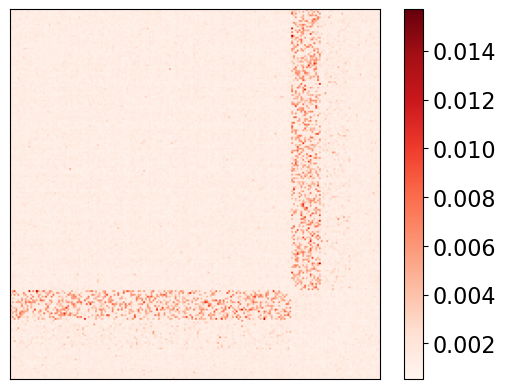

pearson_corr_KK: 0.37062510246703423 spearman_corr_KK: 0.017738480326361945


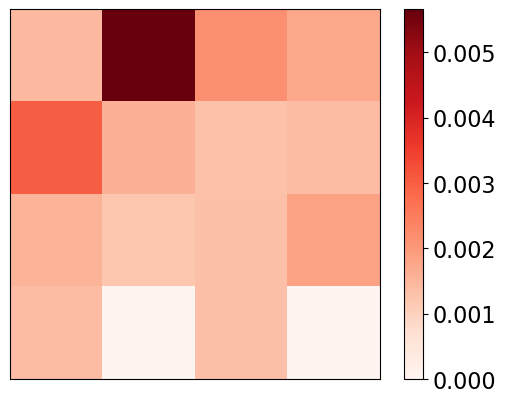

In [18]:
mi = baselines.get_activity_mutual_information(result, tau=1, bins=10)

pearson_corr = np.corrcoef(mi.flatten(), np.abs(weight_matrix).flatten())[0, 1]
spearman_corr = stats.spearmanr(mi.flatten(), np.abs(weight_matrix).flatten())[0]
print('pearson_corr_NN:', pearson_corr, 'spearman_corr_NN:', spearman_corr)

plt.imshow(mi, cmap='Reds')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

KK_strength = tools.NN2KK_remove_no_connection_sim(
    connectivity_matrix_new=mi,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)
pearson_corr_KK = np.corrcoef(KK_strength.flatten(), np.abs(strength_matrix).flatten())[0, 1]
spearman_corr_KK = stats.spearmanr(KK_strength.flatten(), np.abs(strength_matrix).flatten())[0]
print('pearson_corr_KK:', pearson_corr_KK, 'spearman_corr_KK:', spearman_corr_KK)

plt.imshow(KK_strength, cmap='Reds')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()